# 1. Dataset
The dataset we will be using is [IMDB movies review dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) which contains 50,000 reviews on movies with the labels: positive, negative

In [ ]:
import os
import pandas as pd

## 1.1 Kaggle
We will use kaggle to download the dataset.

NOTE: You will need a kaggle.json file, if you do not have it go to your Kaggle profile > account > apis and click "expire api token" and then "create new api token" this should download the kaggle.json file

In [ ]:
from google.colab.files import upload

In [ ]:
print("Installing kaggle")
!pip install kaggle -q
print("Upload kaggle.json")
upload()
print("Setting kaggle up...")
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm -fr sample_data
print("Done!")

## 1.2 Downloading dataset


In [ ]:
DATA_FILENAME = "data.csv"

In [ ]:
if not os.path.exists(DATA_FILENAME):
  !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
  print("\nUnzipping dataset...")
  !unzip -q imdb-dataset-of-50k-movie-reviews.zip
  os.rename("IMDB Dataset.csv", DATA_FILENAME)
  os.remove("imdb-dataset-of-50k-movie-reviews.zip")
  print("Dataset is ready to be cleaned!")

 93% 24.0M/25.7M [00:01<00:00, 23.9MB/s]
100% 25.7M/25.7M [00:01<00:00, 14.9MB/s]

Unzipping dataset...
Dataset is ready to be cleaned!


## 1.3 Get inputs and labels
We will use pandas to read the csv file and store the two columns in thier seperate variables

In [ ]:
df = pd.read_csv(DATA_FILENAME)
df.head(5)

In [ ]:
X = df["review"].values
y = df["sentiment"].values

## 1.4 Splitting into train and test data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [ ]:
print(
f"""
Shape of X_train, y_train: {X_train.shape}, {y_train.shape}
Shape of X_test, y_test: {X_test.shape}, {y_test.shape}
"""
)

## 1.5 Remove punctuation

In [ ]:
from string import punctuation

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
X_train[3]

In [ ]:
for i, review in enumerate(X_train):
  X_train[i] = "".join([c for c in review if c not in punctuation])

In [ ]:
X_train[3]

## 1.6 Tokenize
Here is how we will tokenize:

* Remove stopwords i.e. is, are, am
* Get 1000 most common words in our reviews
* Assign all those 1000 words a numerical value based on popularity
* Create a new list in which the items are the reviews from X_train but the review is made from the 1000 most common words.

In [ ]:
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
class Tokenizer():
  def preprocess_word(self, word):
    # Remove any characters which are not letters
    word = re.sub(r'[^a-zA-Z]+', '', word)
    return word
  
  def _remove_stopwords(self, array):
    word_list = []

    stop_words = set(stopwords.words("english"))
    print("Getting and preprocessing words...")
    for string in tqdm(array):
      for word in string.lower().split():
        word = self.preprocess_word(word)
        if word not in stop_words and word != "":
          word_list.append(word)
    
    return word_list
  
  def tokenize(self, X_train, X_test, y_train, y_test, amount_common_words=1000):
    word_list = self._remove_stopwords(X_train)
    corpus = Counter(word_list) # Get common words
    corpus = sorted(corpus, key=corpus.get, reverse=True)[:amount_common_words] # Sort them based on commonnesss and get x (1000) amount of them
    corpus_num_dict = {w: i+1 for i, w in enumerate(corpus)} # Give numerical value to those common words

    X_train_tok, X_test_tok = [], []

    print(f"\nSetting words in arrays...")
    for review in tqdm(X_train):
      # appends the numerical value of every word in review only if it is in the 1000 most common words (corpus_num_dict)
      X_train_tok.append([corpus_num_dict[self.preprocess_word(word)] for word in review.lower().split() 
                                if self.preprocess_word(word) in corpus_num_dict.keys()])

    for review in tqdm(X_test):
      X_test_tok.append([corpus_num_dict[self.preprocess_word(word)] for word in review.lower().split() 
                                if self.preprocess_word(word) in corpus_num_dict.keys()])
    
    y_train_encodded = [1 if label == "positive" else 0 for label in y_train]
    y_test_encodded = [1 if label == "positive" else 0 for label in y_test]

    print("Tokenized!")

    return np.array(X_train_tok), np.array(y_train_encodded), np.array(X_test_tok), np.array(y_test_encodded), corpus_num_dict

In [ ]:
tokenizer = Tokenizer()

In [ ]:
X_train, y_train, X_test, y_test, vocab = tokenizer.tokenize(X_train, X_test, y_train, y_test)

In [ ]:
len(vocab)

1000

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37500,), (12500,), (37500,), (12500,))

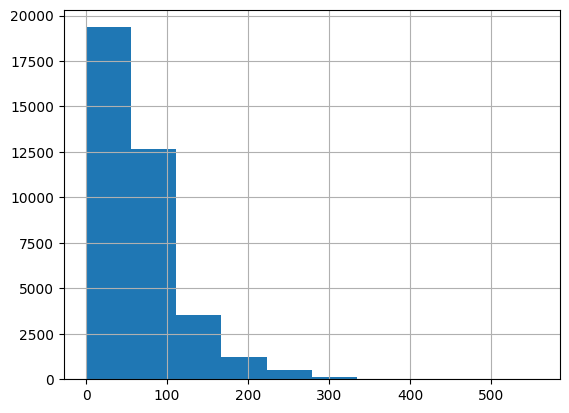

count    37500.000000
mean        69.201547
std         47.932755
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        557.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
print("")
pd.Series(rev_len).describe()

## 1.7 Load dataset

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
batch_size = 50

In [ ]:
def padding(reviews, length):
    features = np.zeros((len(reviews), length),dtype=int)
    for ii, review in enumerate(reviews):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:length]
    return features

In [ ]:
X_train_pad = padding(X_train, 500)
X_test_pad = padding(X_test, 500)

In [ ]:
train_ds = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
test_ds = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

len(train_ds), len(train_dl)

(37500, 750)

In [ ]:
dataiter = iter(train_dl)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.shape) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   2, 675,  13],
        [  0,   0,   0,  ...,   2, 254, 398],
        [  0,   0,   0,  ..., 851, 995, 120],
        ...,
        [  0,   0,   0,  ...,  30, 554, 302],
        [  0,   0,   0,  ..., 344,  97,  33],
        [  0,   0,   0,  ..., 261,  21, 613]])
Sample input: 
 tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1])


# 2. SentimentLSTM
Here is the structure of our neural network

* Embedding Layer
* LSTM
* Dropout Layer (0.5 dropout probability)
* Fully Connected Layer (Sigmoid Activation)

In [ ]:
from torch import nn

In [ ]:
class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, no_layers, output_size):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.no_layers = no_layers

    self.emb = nn.Embedding(vocab_size, embedding_dim)

    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=no_layers, batch_first=True)

    self.dropout = nn.Dropout(0.3)

    self.fc = nn.Linear(self.hidden_dim, output_size)
    self.sig = nn.Sigmoid()
  
  def initialize_hidden_state(self, batch_size):
    hidden_state = torch.zeros([self.no_layers, batch_size, self.hidden_dim]).to(device)
    cell_state = torch.zeros([self.no_layers, batch_size, self.hidden_dim]).to(device)
    return hidden_state, cell_state
  
  def forward(self, input, hidden_state):
    batch_size = input.size(0)
    embeds = self.emb(input) # Shape: B x SL x F
    lstm_out, hidden = self.lstm(embeds, hidden_state)

    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # Reshape into 2D tensor to make it suitable for the fc layer

    out = self.dropout(lstm_out)
    out = self.fc(out)

    sig_out = self.sig(out)

    sig_out = sig_out.view(batch_size, -1)
    sig_out = sig_out[:, -1] # Get predicted labels for each time step
    return sig_out, hidden

In [ ]:
vocab_size = len(vocab) + 1
embedding_dim = 64
hidden_dim = 256
no_layers = 2
output_size = 1

In [ ]:
model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, no_layers, output_size).to(device)
print(model)

SentimentLSTM(
  (emb): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# 3. Loading a pretrained model
Since we have trained our model before and downloaded the h5 file we can import it and simply use that one.

NOTE: The model should be inside of a folder with the name of whatever you want.

ALSO NOTE: If you do not already have a pre-trained model, you can safely skip this section.

Variables to set:
* model_zip_name: The name of zip file (should include the extension)
* model_folder_name: The name of the folder where the model file is contained
* model_filename: The name of the model file (should include the extension)

In [ ]:
import zipfile
from IPython import display

In [ ]:
model_zip_name = "sentiment_analysis_model.zip"
model_folder_name = "model"
model_filename = "model.h5"

In [ ]:
print("Upload model zip file")
upload()
display.clear_output()

In [ ]:
print("Extracting...")
with zipfile.ZipFile(model_zip_name, "r") as zip_ref:
  zip_ref.extractall("./")
print("Done!")

Extracting...
Done!


In [ ]:
print("Loading model...")
model_state_dict = torch.load(os.path.join(model_folder_name, model_filename), map_location=torch.device(device))
model.load_state_dict(model_state_dict)
print(f"\n{model}")

Loading model...

SentimentLSTM(
  (emb): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# 4. Training
Here are the hyperparameters:
* learning rate: 0.001
* optimizer: Adam
* Criterion: Binary Cross Entropy
* Epochs: 5
* Gadient Clipping Value: 5

In [ ]:
from google.colab.files import download

In [ ]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()
epochs = 5
clip_value = 5

In [ ]:
def get_acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
valid_min_loss = np.Inf
train_epoch_accs, valid_epoch_accs, train_epoch_losses, valid_epoch_losses = [], [], [], []
NA = "NA"

for epoch in range(epochs):
  print(f"Epoch: {epoch}")

  train_accuracy = 0.0
  train_losses = []
  
  valid_accuracy = 0.0
  valid_losses = []

  model.train()
  hidden_state = model.initialize_hidden_state(batch_size)

  print("Going through Training and Validation Datasets")
  for inputs, labels in tqdm(train_dl):
    inputs, labels = inputs.to(device), labels.to(device)
    hidden_state = tuple([state.data for state in hidden_state])

    optimizer.zero_grad()
    outputs, hidden_state = model(inputs, hidden_state)
    loss = criterion(outputs.squeeze(), labels.float())
    train_losses.append(loss.item())
    loss.backward()
    batch_acc = get_acc(outputs, labels)
    train_accuracy += batch_acc

    # Stop the exploding gradient problem in LSTMs
    nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    optimizer.step()
  
  model.eval()
  val_hidden_state = model.initialize_hidden_state(batch_size)
  for inputs, labels in tqdm(test_dl):
    inputs, labels = inputs.to(device), labels.to(device)
    val_hidden_state = tuple([state.data for state in hidden_state])

    outputs, val_hidden_state = model(inputs, val_hidden_state)
    loss = criterion(outputs.squeeze(), labels.float())
    valid_losses.append(loss.item())
    batch_acc = get_acc(outputs, labels)
    valid_accuracy += batch_acc

  train_loss = np.mean(train_losses)
  valid_loss = np.mean(valid_losses)
  train_acc = (train_accuracy / len(train_dl.dataset)) * 100
  valid_acc = (valid_accuracy / len(test_dl.dataset)) * 100

  train_epoch_losses.append(train_loss)
  valid_epoch_losses.append(valid_loss)

  train_epoch_accs.append(train_acc)
  valid_epoch_accs.append(valid_acc)

  print("")

  if valid_loss <= valid_min_loss:
    print(f"Validation loss decreased from {NA if valid_min_loss == np.Inf else valid_min_loss} to {valid_loss} ({valid_min_loss - valid_loss} decreased)")
    valid_min_loss = valid_loss
  else:
    print("Validation loss did not decrease")

  print(f"train_loss: {train_loss}, train_acc: {train_acc}")
  print(f"valid_loss: {valid_loss}, valid_acc: {valid_acc}")
  print(30*"=")

Epoch: 0
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from NA to 0.4730487262010574 (inf decreased)
train_loss: 0.5250854787031809, train_acc: 74.12266666666667
valid_loss: 0.4730487262010574, valid_acc: 77.968
Epoch: 1
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from 0.4730487262010574 to 0.4064160332083702 (0.0666326929926872 decreased)
train_loss: 0.5452033914724985, train_acc: 69.416
valid_loss: 0.4064160332083702, valid_acc: 81.824
Epoch: 2
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from 0.4064160332083702 to 0.35593443751335146 (0.050481595695018755 decreased)
train_loss: 0.4080655903617541, train_acc: 82.34133333333334
valid_loss: 0.35593443751335146, valid_acc: 84.368
Epoch: 3
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from 0.35593443751335146 to 0.34617546743154526 (0.009758970081806206 decreased)
train_loss: 0.3367874853213628, train_acc: 85.70400000000001
valid_loss: 0.34617546743154526, valid_acc: 84.824
Epoch: 4
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from 0.34617546743154526 to 0.33440550130605695 (0.011769966125488307 decreased)
train_loss: 0.3139531066715717, train_acc: 86.88533333333334
valid_loss: 0.33440550130605695, valid_acc: 85.2


In [ ]:
if not os.path.isdir("model"):
  os.mkdir("model")

In [ ]:
torch.save(model.state_dict(), "model/model.h5")

In [ ]:
!zip -r sentiment_analysis_model.zip model
download("sentiment_analysis_model.zip")

  adding: model/ (stored 0%)
  adding: model/model.h5 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Analysis

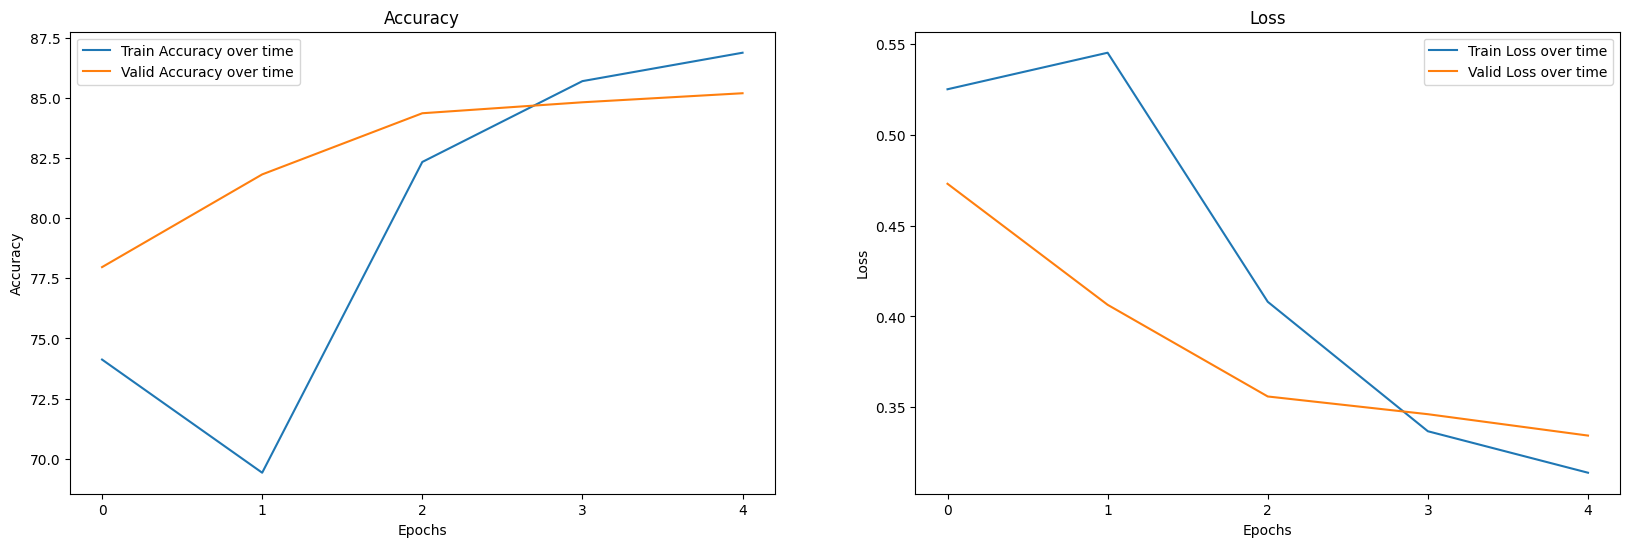

In [ ]:
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(train_epoch_accs, label="Train Accuracy over time")
plt.plot(valid_epoch_accs, label="Valid Accuracy over time")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks([0,1,2,3,4])
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(train_epoch_losses, label="Train Loss over time")
plt.plot(valid_epoch_losses, label="Valid Loss over time")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks([0,1,2,3,4])
plt.legend()


plt.show()

Here we can see that the validation accuracy and loss have not started flatten which indicates that we can achieve better performance with more training. We will leave it as is for now.

# 6. Testing
Now we can give our model some text and it will give us a sentiment!

In [ ]:
import random

In [ ]:
def predict_text(text):
  word_list = [vocab[tokenizer.preprocess_word(word)] for word in text.lower().split() if tokenizer.preprocess_word(word) in vocab.keys()]
  word_list = np.expand_dims(word_list, axis=0)
  pad_word_list = torch.from_numpy(padding(word_list, 500)).to(device)
  h = model.initialize_hidden_state(batch_size=1)
  h = tuple([state.data for state in h])
  prob, h = model(pad_word_list, h)
  prob = prob.item()

  label = "positive" if prob > 0.5 else "negative"
  prob = (1 - prob) if label == "negative" else prob

  confidence = round(prob*100)
  return prob, confidence, label

In [ ]:
index = random.randrange(0, len(test_dl.dataset))
text = df['review'][index]
true_sentiment = df['sentiment'][index]

prob, confidence, pred_label = predict_text(text)

print(text)
print('='*70)
print(f'Actual sentiment is: {true_sentiment}')
print(f"Predicted sentiment: {pred_label} with {confidence}% confidence")

Primal Species (1996, Dir. Jonathan Winfrey) <br /><br />International terrorists get a surprise when their cargo turn out to contain living dinosaurs. The army commando team now have to think fast, if they want to prevent the extinction of the human species, instead of the reptiles.<br /><br />You look at the cover and you gain your first impressions of the film. That is pretty much it. The acting is only just acceptable from a few characters. The story is poor, with the whole film based on the army and the marines trying to kill the dinosaurs. This film came out three years after 'Jurassic Park'. Instead, this film looks to have come out 13 years before 'Jurassic Park'. The dinosaurs costumes are so poorly made, and i do mean costumes. There are obviously people dressed up, and this film makes no attempts at hiding this. A scene when a dinosaur runs down a corridor is created in a way, in which it looks like someone is riding the creature. The is one good thing, which comes out of th